<a href="https://colab.research.google.com/github/laura-turnbull-lloyd/Taiwan_connectivity_workshop/blob/main/Connectivity_part2_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Connectivity workshop: Part 2**
# John Wainwright and Laura Turnbull
# 3rd June 2025

#**A practical application: calculating SC-FC relations for rainfall-runoff events at the Walnut Gulch Experimental Watershed, USA**

In this practical exercise we will focus on hydrological connectivity at a much larger spatial scale: the watershed scale. We will explore how to use watershed structure data and hydrological time-series data to quantify structural and functional connectivity within an ephemeral watershed. Although the focus of analysis here is the watershed scale, it is nevertheless important to consider how local- and global-scale connectivity properties at the hillslope scale shape the larger hydrological reponse.

We will calculate structural-functional connectivity (SC-FC) correlations for two types of connectivity that were introduced in a paper by Voutsa et al (2021):

* **synchronous connectivity** - characterizes connectivity based on a synchronized response
* **sequential connectivity** - characterizes connectivity based on a lagged connected response through a watershed

##Getting started
We will undertake this analysis using several python packages
* Numpy - a mathematical operations package
* Pandas - a data analysis and data manipulation tool
* Matplotlib - a comprehensive library for creating visulaizations
* Networkx - one of the main python libraries for analyzing networks

## Installing/loading the packages
Google colab has most packages pre-installed, but we will be using one called datatree which we have to install manually. The rest can simply be loaded from within the python notebook.

In [1]:
#installs a package
!pip install git+https://github.com/xarray-contrib/datatree

#loads packages
import numpy as np
import pandas as pd
import networkx as nx
import xarray as xr
import datatree as dtree
from itertools import permutations
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import requests

  Cloning https://github.com/xarray-contrib/datatree to /tmp/pip-req-build-8zu1weob
  Running command git clone --filter=blob:none --quiet https://github.com/xarray-contrib/datatree /tmp/pip-req-build-8zu1weob
  Resolved https://github.com/xarray-contrib/datatree to commit 5f3956ffe80e686dd3df54ee8cef9ff56c158e76
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.3 MB/s eta 0:00:00
  Created wheel for xarray-datatree: filename=xarray_datatree-0.0.15-py3-none-any.whl size=64292 sha256=bd84be1b151f71f031f4842b1c350fd2f896f19229b4af6cb9cdf5b12981db6b
  Stored in directory: /tmp/pip-ephem-wheel-cache-6is_vabh/wheels/a2/ea/b5/29b0b1be6df80f9e097e22552a4e71e98738f2ca4a0b916f02
Successfully built xarray-datatree
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.3.1
    Uninstalling xarray-2025.3.1:
      Successfully uninstalle

#Loading the data
The data you will use in this practical are preloaded on a github page [here](https://github.com/laura-turnbull-lloyd/Taiwan_connectivity_workshop/tree/main/data), for easy access.

The data consist of:
* flume_watersheds - a file containing the contributing are to each flume in the watershed
* df_sc_seq_extended - the edgelist for the sequential structural connectivity
* rain_runoff_summary - flow data and event average rainfall at the watershed outlet
* flume_coordinates_final - coordinates of the flumes

To load the data in .csv format, we can call it from a url:

In [2]:
# Set url for the different data sets we'll be using
flume_watersheds = 'https://raw.githubusercontent.com/laura-turnbull-lloyd/Taiwan_connectivity_workshop/main/data/Flume_watersheds.csv'
df_sc_seq_extended = 'https://raw.githubusercontent.com/laura-turnbull-lloyd/Taiwan_connectivity_workshop/main/data/df_sc_seq_extended.csv'
flume_coordinates = 'https://raw.githubusercontent.com/laura-turnbull-lloyd/Taiwan_connectivity_workshop/main/data/flume_coordinates_final.csv'
edgelist = 'https://raw.githubusercontent.com/laura-turnbull-lloyd/Taiwan_connectivity_workshop/main/data/edgelist.csv'
rain_runoff_summary = 'https://raw.githubusercontent.com/laura-turnbull-lloyd/Taiwan_connectivity_workshop/main/data/rain_runoff_summary.csv'


The flow data we will use to calculate functional connectivity are provided for you in a 'netcdf' file. These data have been collected by the United States Department of Agriculture, and the original version can be found [here](https://www.tucson.ars.ag.gov/dap/). For simplicity, these continuous time-series data, featuring lots of 0 values as the system is ephemeral, have been processed into discrete rainfall-runoff events. As we're interested in connectivity, all the events contained within the flow dataset have at least 5 flumes activated.

For the flow data stored in netcdf format (this is a compressed file format that's useful for storing large volumes of data), we will first open the file locally (the netcdf package can't load data directly from a url!) and then open it within the netcdf package.

In [3]:
#for the netcdf file, we will first open this locally (it's just to do with a quirk of the netcdf package)
runoff_events_url = 'https://raw.githubusercontent.com/laura-turnbull-lloyd/Taiwan_connectivity_workshop/main/data/runoff_events_2000_2006.nc'
runoff_events_local_path = 'runoff_events_2000_2006.nc'

response = requests.get(runoff_events_url)
with open(runoff_events_local_path, 'wb') as f:
    f.write(response.content)

#Structural connectivity

We will start off the analysis with a look at the structural connectivity of the system.

We differentiate between two structural connectivity networks, one to capture the synchronous activity of the runoff and one to capture the sequential activity, i.e. the water flow between upslope and downslope locations.

Our conceptualization is based on the following rationale:

**Synchronous connectivity** results from rapid and simultaneous hydrological response, where the timing and shape of the runoff response are consistent across multiple locations. Hence,  flumes that are close in space (i.e. in adjacent sub-watersheds), but not necessarily located upslope/downslope can be activated simultaneously. For this reason, the inverse Euclidean distance is an appropriate feature to be used in deriving the $SC_{sync}$ network, because it draws stronger links between flumes that lie in closer proximity to one another. In addition, because of the way that hydrological processes scale with watershed area,  we can expect a more similar hydrological response for flumes that have similar contributing areas. Therefore, weights describing the similarity of the channels with respect to the size of their contributing areas can be added as an additional feature in the $SC_{sync}$ in order to in order to characterise the overall possibility space in which $FC_{sync}$ can occur.

**Sequential connectivity** on the other hand, represents the processed-based connectivity of water flowing through the river network, and depends on the opportunity time for water to infiltrate into the channel bed. Thus, the length of the channel as well as the average channel slope between two flumes are two key structural features that affect how the water flows through this type of ephemeral system. Shorter channel lengths and steeper slopes contribute to stronger structural connections between the flumes.

The weighted $SC$ matrices are described as follows:

\begin{equation}
\begin{split}
SC_{sync_{ij}} &=   \frac{1}{d_{ij}} + \frac{min{(C_{i}, C_{j}})}{max{(C_{i}, C_{j}})} , \\
SC_{seq_{ij}} &=  \frac{1}{l_{ij}} + S_{ij} ,
\end{split}
\end{equation}

where $C_{i}$, $C_{j}$ are the contributing areas in $km^2$ for the flumes $i$ and $j$, $d_{ij}$ is the Euclidean distance between flumes, $l_{ij}$ is the channel length between flume $i$ and flume $j$ and $S_{ij}$ the slope of the channel in percent.

##Synchronous structural connectivity
There are various stages involved in calculating the synchronous structural connectivity.

The function below calculates the inverse distance between a pair of flumes.

In [4]:
def eucleidian_distance(flume_pair):
    flume1 = df_flume_coordinates[df_flume_coordinates['Flume'] == flume_pair[0]]
    flume2 = df_flume_coordinates[df_flume_coordinates['Flume'] == flume_pair[1]]

    distance = np.sqrt((flume1.East.values - flume2.East.values)**2 + (flume1.North.values - flume2.North.values)**2)

    return np.round(distance[0], 2).item()


Next, we read in the flume coordinates, generate a lost of all possible pairs of flumes in the watershed, and determine inverse of the euclidean distance between flumes and the similarity of their contributing area.

In [5]:
# SCsim

# Read in the spatial data that is used to calculate synchronous structural connectivity
df_flume_coordinates = pd.read_csv(flume_coordinates)
df_contributing_area = pd.read_csv(os.path.join(flume_watersheds),index_col = 0)

# Generate all possible ordered pairs (i.e., directed pairs) of length 2 from the list of flume names
edges_eucl_distance = list(permutations(df_flume_coordinates['Flume'], 2))

# Convert to a dataframe of all possible flume pairs
df_sc_sim = pd.DataFrame(edges_eucl_distance, columns=['flume 1', 'flume 2'])

# Calculate the euclidean distance between each pair of flumes
distances = []
for flume_pair in edges_eucl_distance:
    distances.append(eucleidian_distance(flume_pair))

# Take the inverse of the euclidean distance between flumes, in km
weights = [1/np.round(dist/1000, 2).item() for dist in distances]
df_sc_sim['weight dist'] = weights

# Calculate a similarity metric based on contributing area for each flume pair in df_sc_sim, and store the result in a list called sc_contributing_area.
sc_contributing_area = []

for i in range(len(df_sc_sim)):
    flume1 = df_sc_sim['flume 1'].iloc[i]
    flume2 = df_sc_sim['flume 2'].iloc[i]
    area1 = df_contributing_area[df_contributing_area['Flume'] == flume1].Contributing_area_km2.iloc[0]
    area2 = df_contributing_area[df_contributing_area['Flume'] == flume2].Contributing_area_km2.iloc[0]
    sc_contributing_area.append(min(area1, area2)/max(area1, area2)) #abs(area1 - area2)

df_sc_sim['weight contr area'] = sc_contributing_area

# Calculate an overall weight by combining the two weighting metrics (euclidean distance and contributing area similarity)
df_sc_sim['weight'] =( df_sc_sim['weight dist'] + df_sc_sim['weight contr area'])/2

# Get all unique flumes
flumes = sorted(set(df_sc_sim['flume 1']).union(df_sc_sim['flume 2']))
flume_indices = {flume: idx for idx, flume in enumerate(flumes)}

# Create empty adjacency matrix
adj_sim_mix = np.zeros((len(flumes), len(flumes)))

# Populate the adjacency matrix with the calculated weights
for ii, row in df_sc_sim.iterrows():
    i = flume_indices[row['flume 1']]
    j = flume_indices[row['flume 2']]
    adj_sim_mix[i][j] = row['weight']

# Convert the adjacency matrix to a pandas dataframe
adj_sim_mix = pd.DataFrame(adj_sim_mix, index=flumes, columns=flumes)

# Uncomment the line below if you wish to view the adjacency matrix
# print(adj_sim_mix)

##Plotting out the adjacency matrix
It's often useful to plot out the adjacency matrix because it gives you a visual overview of network structure. It shows which nodes within the network have a high value (note that often adjacency matrices are binary -- 0 and 1s, representing simply whether there is or isn't a link).

The adjacency matrix enables us to quickly see if there are patterns in the network, or certain highly connected nodes.

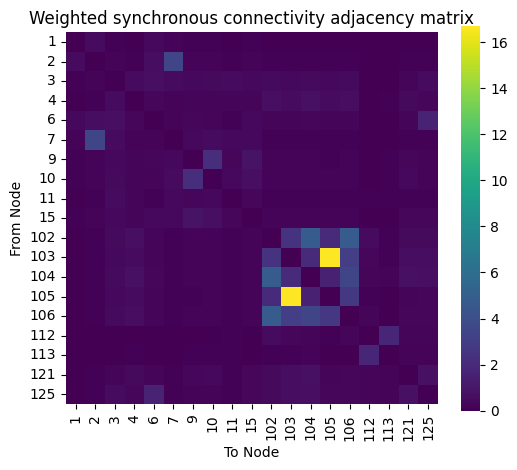

In [7]:
# To plot the adjacency matrix
plt.figure(figsize=(6, 5))
sns.heatmap(adj_sim_mix, annot=False, cmap="viridis", square=True)
plt.title("Weighted synchronous connectivity adjacency matrix")
plt.xlabel("To Node")
plt.ylabel("From Node")
plt.show()

**Question:** What does this weighted adjacency matrix tell you about the structure of the network?


In [8]:
#To plot the synchronous connectivity network

#Create the graph
G = nx.from_pandas_adjacency(adj_sim_mix, create_using=nx.DiGraph)

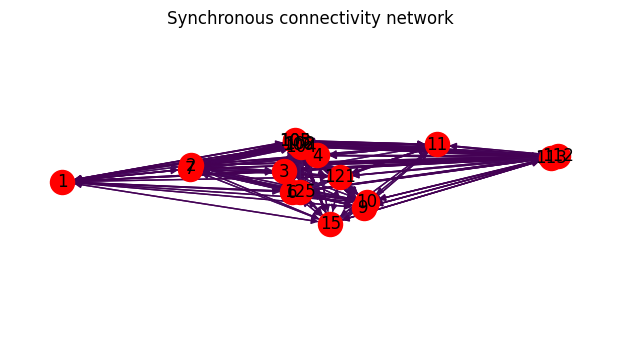

In [9]:
#Extract the spatial positions to use to plot the spatial network
# Use 'Flume' as node ID, with East/North as coordinates
pos = {row['Flume']: (row['East'], row['North']) for _, row in df_flume_coordinates.iterrows()}

# Plot with spatial positions
plt.figure(figsize=(6, 3))
edges = G.edges(data=True)
weights = [d['weight'] * 5 for (u, v, d) in edges]  # scale weights for visibility

nx.draw(
    G, pos=pos, with_labels=True, node_color='red',
    edge_color=weights, width=1, node_size=300
)
plt.title("Synchronous connectivity network")
plt.axis("equal")
plt.show()



#Sequential structural connectivity
Calculating sequential connectivity is much simpler, because the network is much smaller, as the sequential connectivity network is directed.

Building the sequential structural connectivity network requires the location of nodes, the distance between flumes (the distance through the channel network, rather than the euclidean distance, as this is a more meaningful distance measure in this context), and the average channel slope.

Adjacency matrices are created separately for each weighting variable, and then combined, with equal weighting, to reflect the combined effect of channel length and slope on overall edge weight.


In [10]:
# SCseq
df_edges_seq = pd.read_csv(os.path.join(edgelist), index_col = 0)
df_sc_seq = pd.read_csv(df_sc_seq_extended, index_col = 0)

# Create adjacency matrices for 'weight length' and 'slope_percent'
adj_matrices = {}
for col in ['weight length', 'slope_percent']:
    df = df_sc_seq[['source', 'target', col]].rename(columns={col: 'value'})
    all_labels = sorted(set(df['source']).union(df['target']))
    adj_matrices[col] = df.pivot(index='source', columns='target', values='value').reindex(index=all_labels, columns=all_labels)

# Combine both matrices (equivalent to equal weighting)
adj_seq_mix = 0.5*adj_matrices['weight length'] + 0.5*adj_matrices['slope_percent']


In [11]:
#To view the adjacency matrix
adj_seq_mix

target,1,2,3,4,6,7,9,10,11,15,102,103,104,105,106,112,113,121,125
source,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.587133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.542046,0.586812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.555454,0.600325,0.874918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.529174,0.551136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.594832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.504476,0.497467,NaN,NaN,0.551943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0.507327,0.502441,NaN,NaN,0.561753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0.547158,0.564812,NaN,NaN,0.634395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


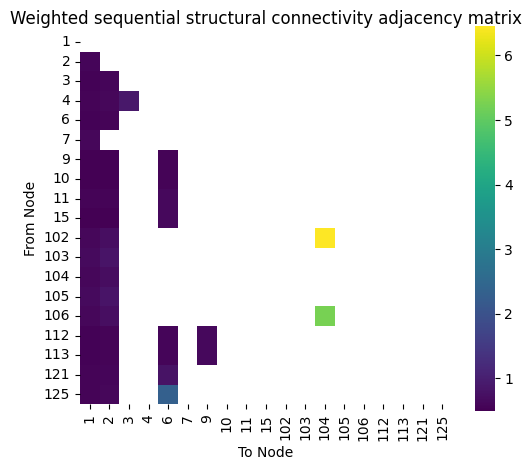

In [12]:
# To plot the adjacency matrix
plt.figure(figsize=(6, 5))
sns.heatmap(adj_seq_mix, annot=False, cmap="viridis", square=True)
plt.title("Weighted sequential structural connectivity adjacency matrix")
plt.xlabel("To Node")
plt.ylabel("From Node")
plt.show()

##Viewing this adjacency matrix as a graph

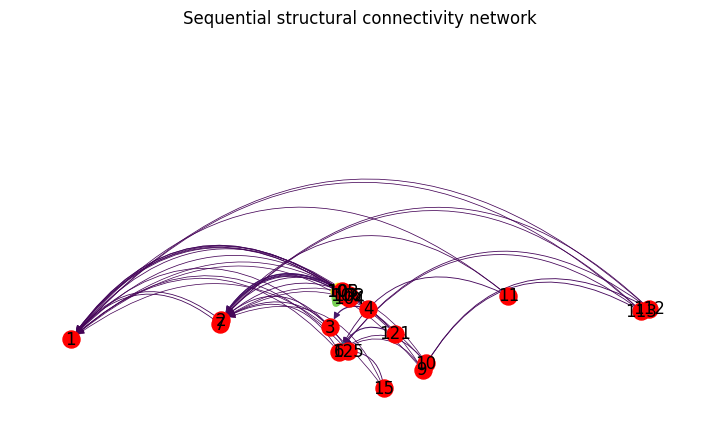

In [13]:
#Create the graph
G_seq = nx.from_pandas_adjacency(adj_seq_mix, create_using=nx.DiGraph)

# Filter edges that have non-NaN weights
edges = [(u, v, d) for u, v, d in G_seq.edges(data=True) if not np.isnan(d['weight'])]
edge_tuples = [(u, v) for u, v, _ in edges]
weights = [d['weight'] for _, _, d in edges]

# Plot
plt.figure(figsize=(7, 4))
nx.draw(
    G_seq,
    pos=pos,
    edgelist=edge_tuples,
    edge_color=weights,
    edge_cmap=plt.cm.viridis,
    width=[w * 1 for w in weights],
    with_labels=True,
    node_color='red',
    node_size=150,
    connectionstyle='arc3,rad=0.5'  # curves the edges
)
plt.axis("equal")
plt.title("Sequential structural connectivity network")
plt.show()

You will see in this graph that a downstream flume is connected to all upstream flumes. This way, the functional connectivity between non-adjacent flumes is assessed.

#Sequential functional connectivity calculations

First, we will set up a function that calculates  $FC_{seq}$  for each event. Recall that quantifying  $FC_{seq}$  between flumes is a lagged correlation analysis, where the lag time used in the calculations is a simple approximation of flow travel times under "average" conditions.

In [14]:
#Setting node labels
flume_labels = [f'flume_{i}' for i in all_labels]
flume_labels

['flume_1',
 'flume_2',
 'flume_3',
 'flume_4',
 'flume_6',
 'flume_7',
 'flume_9',
 'flume_10',
 'flume_11',
 'flume_15',
 'flume_102',
 'flume_103',
 'flume_104',
 'flume_105',
 'flume_106',
 'flume_112',
 'flume_113',
 'flume_121',
 'flume_125']

In [15]:
def compute_fc_seq_for_event(df_complete, flume_labels, df_edges_seq):
    """
    Compute functional connectivity sequence matrix for one event's data.

    Args:
        df_complete (pd.DataFrame): DataFrame with flume data aligned to flume_labels.
        flume_labels (list): List of flume labels (e.g., ['flume_1', 'flume_2', ...]).
        df_edges_seq (pd.DataFrame): Edges DataFrame with 'source', 'target', and 'time-delay mins'.

    Returns:
        np.ndarray: fc_seq matrix of correlations adjusted for time delays.
    """
    T = len(df_complete)
    n_flumes = len(flume_labels)
    fc_seq = np.zeros((n_flumes, n_flumes))

    for idx in range(len(df_edges_seq)):
        flume1 = f"flume_{df_edges_seq['source'].iloc[idx]}"
        flume2 = f"flume_{df_edges_seq['target'].iloc[idx]}"

        if flume1 in flume_labels and flume2 in flume_labels:
            i1 = flume_labels.index(flume1)
            i2 = flume_labels.index(flume2)

# here we used a pre-defined time delay, read in from the input file
            if not (np.isnan(df_complete[flume1].iloc[0]) or np.isnan(df_complete[flume2].iloc[0])):
                t_delay = int(round(df_edges_seq['time-delay mins'].iloc[idx], 0))
                if T > t_delay:
                    runoff_flume1 = df_complete[flume1].iloc[0:(T - t_delay)]
                    runoff_flume2 = df_complete[flume2].iloc[t_delay:T]

                    corr_val = np.corrcoef(runoff_flume1, runoff_flume2)[0, 1]
                    fc_seq[i1, i2] = np.round(corr_val, 2)

    return np.nan_to_num(fc_seq)


Now that we have set up the function to calculate  $FC_{seq}$, we need to open the flow data:

In [16]:
# load runoff data
tree = dtree.open_datatree('runoff_events_2000_2006.nc', format="NETCDF4")

We can view the structure of the data stored in the netcdf file by printing it out:

In [17]:
print(tree)

DataTree('None', parent=None)
├── DataTree('event_0')
│       Dimensions:    (time: 369)
│       Coordinates:
│         * time       (time) datetime64[ns] 3kB 2000-06-17T14:51:15 ... 2000-06-17T2...
│       Data variables:
│           flume_2    (time) float64 3kB ...
│           flume_3    (time) float64 3kB ...
│           flume_4    (time) float64 3kB ...
│           flume_6    (time) float64 3kB ...
│           flume_10   (time) float64 3kB ...
│           flume_11   (time) float64 3kB ...
│           flume_15   (time) float64 3kB ...
│           flume_121  (time) float64 3kB ...
├── DataTree('event_1')
│       Dimensions:   (time: 350)
│       Coordinates:
│         * time      (time) datetime64[ns] 3kB 2000-06-18T17:28:15 ... 2000-06-18T23...
│       Data variables:
│           flume_2   (time) float64 3kB ...
│           flume_3   (time) float64 3kB ...
│           flume_4   (time) float64 3kB ...
│           flume_6   (time) float64 3kB ...
│           flume_11  (time) float64 

We can see above that there's a group, containing an "event identifier". We can use this ID to extract data from the netcdf file for a single event at a time.

In [18]:
event_labels = []
for node in tree.descendants:
    event_labels.append(node.name)

#Explore the data for a single event
The runoff data is vast, and therefore, to become familiar with the data, and to walk though the functional connectivity calculations, we'll first explore the data for a single flow event.

Starting with ```event_0```, we can subset the data for this event, and then view the properties of the data, using the ```print``` command:


In [19]:
xr_event = tree['event_0']
ds_event = xr_event.to_dataset()
print(tree['event_0'])

DataTree('event_0', parent="None")
    Dimensions:    (time: 369)
    Coordinates:
      * time       (time) datetime64[ns] 3kB 2000-06-17T14:51:15 ... 2000-06-17T2...
    Data variables:
        flume_2    (time) float64 3kB ...
        flume_3    (time) float64 3kB ...
        flume_4    (time) float64 3kB ...
        flume_6    (time) float64 3kB ...
        flume_10   (time) float64 3kB ...
        flume_11   (time) float64 3kB ...
        flume_15   (time) float64 3kB ...
        flume_121  (time) float64 3kB ...


From this we can see that the group (event_0) contains a dataset with:

* 1 coordinate: time, which has the date and time stamp

* Flow measurements for individual flumes (e.g., flume_2, flume_3, ..., flume_121)

Now we will visualize the hydrographs:

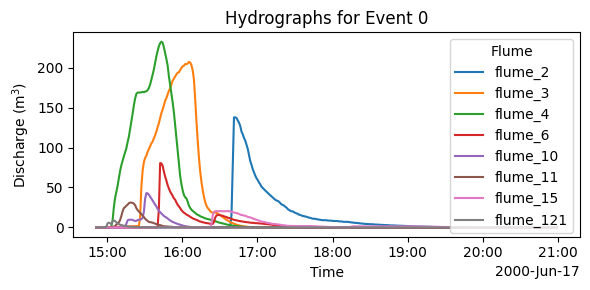

In [20]:
ds = tree['event_0'].ds

# Plot each flume's hydrograph
plt.figure(figsize=(6, 3))

for var in ds.data_vars:
    ds[var].plot(label=var)

plt.title("Hydrographs for Event 0")
plt.xlabel("Time")
plt.ylabel("Discharge (m$^3$)")
plt.legend(title="Flume")
plt.tight_layout()
plt.show()

#Task
Have a go at plotting the hydrographs for other flow events by changing the event number in `ds = tree['event_0'].ds`

You should start to get a feel for how the spatial and temporal patterns of flow within the watershed vary for different rainfall-runoff events.

#Calculating correlation-based functional connectivity for Event 8
We'll first take a look at Event 8, as this is the largest event within this dataset.

First, view the hydrographs for Event 8. You can either view it in the code block above, or add a new code block below, and modify the code accordingly.


In [60]:
# Code to look at both types of functional connectivity for event 8
# Set the event label to process
event_label = 'event_8'  # <-- change this as needed

# Convert structural adjacency matrices to numpy arrays
#adj_sim_mix = np.array(adj_sim_mix)
#adj_seq_mix = np.array(adj_seq_mix)
adj_seq_mix = np.nan_to_num(np.array(adj_seq_mix), nan=0)

# Access the event dataset
xr_event = tree[event_label]
ds_event = xr_event.to_dataset()

# Prepare the time series DataFrame
df_complete = pd.DataFrame(columns=flume_labels)
df = ds_event.to_dataframe()
common_columns = df_complete.columns.intersection(df.columns)
df_complete[common_columns] = df[common_columns]

Let's pause again here to look at the structure of the data:

In [ ]:
df_complete

The dataframe is made up or rows of data, with a date/time stamp, and colums that contain flow data for each flume. Flumes with no flow contain "NaN".

# Calculating functional connectivity
Now that the data is appropriately formatted, we can calculate two types of functional connectivity between nodes (flumes).

The mathematical expression for the $FC$ matrices is  

\begin{equation}
FC_{sync_{ij}} = \text{corr}_{t}(Q_{i}(t), Q_{j}(t))
\end{equation}
\begin{equation}
FC_{seq_{ij}} = \text{corr}_{t}(Q_{i}(t), Q_{j}(t + \tau_{ij}))
\end{equation}

where $Q_{i}(t)$ is the time series of runoff rate of flume $i$ within an individual event, $\tau_{ij}$ is the average time required for the water to reach flume $j$ from flume $i$ and it is calculated as a time-delay in the hydrographs to construct the $FC_{seq}$ matrix.



In [62]:
# Compute functional connectivity (correlation)
fc_sim = df_complete.corr().fillna(0).to_numpy()

# Compute sequential functional connectivity (custom function)
fc_seq = compute_fc_seq_for_event(df_complete, flume_labels, df_edges_seq)


**Recap:** Here we have calculated the correlation of hydographs between nodes. In the case of $FC_{seq}$, the correlation includes a lag time.

Now, the functional connectivity adjacency matrices contain a correlations we've just calculated, which, in this conceptualization of connectivity, is the strength of connectivity between nodes.

Let's view the adjacency matrix for $FC_{seq}$.

This time, we'll use a red-white-blue colour scale, where the colour indicates the strength and direction (+ve, -ve) of the correlation.

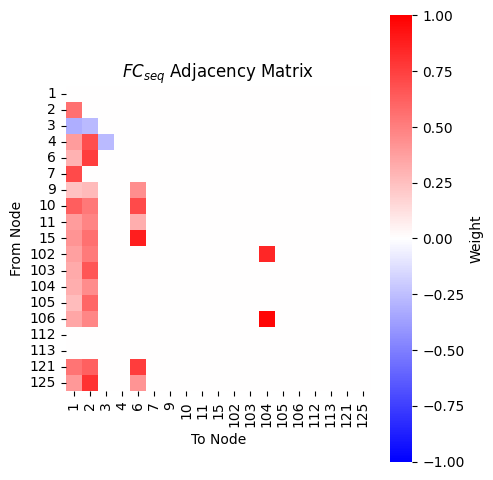

In [46]:
# Convert the fc_seq matrix into a pandas dataframe to plot out the adjacency matrix
fc_seq_df = pd.DataFrame(fc_seq, index=flumes, columns=flumes)

plt.figure(figsize=(5, 5))
sns.heatmap(
    fc_seq_df,
    cmap='bwr',        # blue-white-red colormap
    center=0,          # white centered at zero
    square=True,
    vmin=-1,        # lower limit of the color scale
    vmax=1,         # upper limit of the color scale
    cbar_kws={"label": "Weight"}
)

plt.title("$FC_{seq}$ Adjacency Matrix")
plt.xlabel("To Node")
plt.ylabel("From Node")
plt.tight_layout()
plt.show()


#Task
Have a go at modifying the code to view the $FC_{sim}$ adjacency matrix.

In [25]:
# Have a go at entering code here (you can copy and past the above example and edit the relevant bits!) to plot out the $FC_{sim}$ adjacency matrix


#Vizualizing the $FC_{seq}$ network
We can now visualize the spatial patterns of $FC_{seq}$, by creating the graph from the adjacency matrix, and then drawing the spatial network using networkx and the node coordinates, as we did before.

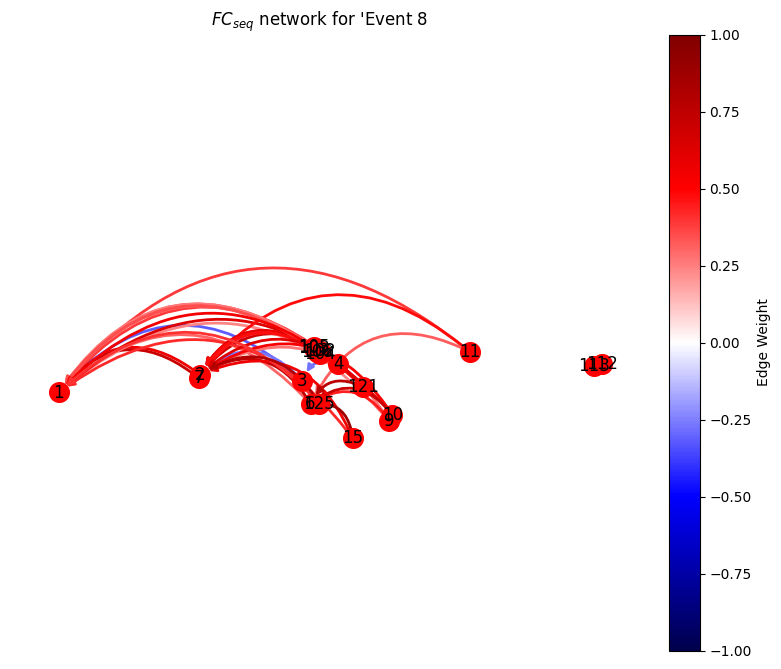

In [63]:
#Create the graph
G_FCseq = nx.from_pandas_adjacency(fc_seq_df, create_using=nx.DiGraph)

# Filter edges that have non-NaN weights
edges = [(u, v, d) for u, v, d in G_FCseq.edges(data=True) if not np.isnan(d['weight'])]
edge_tuples = [(u, v) for u, v, _ in edges]
weights = [d['weight'] for _, _, d in edges]

# Use a diverging colormap: blue (low) → white (mid) → red (high)
cmap = plt.cm.seismic
norm = colors.Normalize(vmin=-1, vmax=1)  # fix scale from -1 to 1

# Create figure and axis — this is what you were missing
fc_fig, ax = plt.subplots(figsize=(10, 8))

# Draw the graph
nx.draw(
    G_FCseq,
    pos=pos,
    with_labels=True,
    node_color='red',
    edge_color=weights,
    edge_cmap=cmap,
    edge_vmin=-1, edge_vmax=1,
    width=2,
    node_size=200,
    connectionstyle='arc3,rad=0.5'  # curves the edges
)


# Add colorbar to this axis
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fc_fig.colorbar(sm, ax=ax)
cbar.set_label("Edge Weight")

plt.title("$FC_{seq}$ network for 'Event 8")
plt.axis("equal")
plt.show()

# SC/FC correlations

So far we have calculated the SC and FC adjacency matrices for both types of connectivity. This allows us to visualize local patterns of connectivity, rather like the local metrics you calculated earlier.

As an overall indicator of the extent to which functional connectivity occupies the structural space upon which connectivity can occur, i.e. the structural connectivity template, we can calculate the SC/FC correlation. This correlation (the Pearson correlation) is equivalent to the global connectivity measures introduced earlier, where a single measure gives an overall indication of some characteristic of connectivity within a network.

Now for the details...

Before undertaking SC/FC correlations, we need to remove the diagonals from the adjacency matrix (where the correlation is 1!):

In [64]:
def remove_diagonal(A):

    return A[~np.eye(A.shape[0],dtype=bool)].reshape(A.shape[0],-1)

We are then in a position to calculate the SC/FC correlation using this function:

In [65]:
def sc_fc_correlations(adj_matrix, fc_sim, fc_seq):

    adj_matrix_no_diag = remove_diagonal(adj_matrix)
    fc_sim_no_diag = remove_diagonal(fc_sim)
    fc_seq_no_diag = remove_diagonal(fc_seq)
    sc_fc_sim = np.corrcoef(adj_matrix_no_diag.flatten(), fc_sim_no_diag.flatten())[0][1]
    sc_fc_seq = np.corrcoef(adj_matrix_no_diag.flatten(), fc_seq_no_diag.flatten())[0][1]

    return sc_fc_sim, sc_fc_seq

#Calculating SC-FC correlations
So far we have calculated adjacency matrices for structural connectivity and functional connectivity. These give us detailed infromation on the level of connectivity between nodes in the network, in both a static (i.e. structural) and dynamic (i.e. functional) sense.

As an overall measure of connectivity, we can calculate the SC-FC correlation. Recall that structural connectivity is essentially the possiblity space over which the funcitonal connecticity can operate.

The SC-FC correlation gives an overall indication of the extent to which the FC occupies the structural space over which a connected runoff response can occur.

In [66]:
# Remove diagonals and flatten for correlation
adj_flat = remove_diagonal(adj_sim_mix).flatten()
fcsim_flat = remove_diagonal(fc_sim).flatten()

adj_flat_mix = remove_diagonal(adj_seq_mix).flatten()
fcseq_flat = remove_diagonal(fc_seq).flatten()

# Compute SCFC metrics
scfc_sim = np.corrcoef(adj_flat, fcsim_flat)[0][1]
scfc_sim_norm = scfc_sim * (len(xr_event.data_vars) / len(flume_labels))

scfc_seq_mix = np.corrcoef(adj_flat_mix, fcseq_flat)[0][1]
scfc_seq_norm_mix = scfc_seq_mix * (len(xr_event.data_vars) / len(flume_labels))

# Package results into a DataFrame
df_scfcs = pd.DataFrame({
    'event':[event_label],
    'scfc_sim': [scfc_sim_norm],
    'scfc_seq': [scfc_seq_norm_mix]
}).fillna(0)

# Display result
print(df_scfcs)

     event  scfc_sim  scfc_seq
0  event_8   0.25147  0.564632


As you can see, the SC-FC correlation for each type of connectivity is a single value that expresses the degree of correlation between the SC adjacency matrix and the FC adjacency matrix.

The SC-FC correlation is another type of global (i.e. network level) connectivity measure, that characterizes connectivity propoerties of the entire network, and in this case, it expresses properties of the FC network in relation to the SC network, which is a step beyond the global measures you explored earlier.

You've now walked through all the stages of $FC_{sim}$, $FC_{seq}$ and *SC-FC correlation* calculations for a single event.

With all the data stored in the netcdf file, for the period between 2000 and 2006, we can loop through each event to calculate the SC, FC and SC-FC correlation values, as follows:

In [68]:
adj_sim_mix = np.array(adj_sim_mix)#(df1 + df2)/2) #adj_sim_mix.fillna(0))
adj_seq_mix = np.array(adj_seq_mix)

scfcs = {}
scfcs['scfc_sim'] = []
scfcs['scfc_seq'] = []

for label in event_labels:
    xr_event = tree[label]
    ds_event = xr_event.to_dataset()

    df_complete = pd.DataFrame(columns=flume_labels)
    df = ds_event.to_dataframe()
    common_columns = df_complete.columns.intersection(df.columns)

    # Map the common columns to df_complete
    df_complete[common_columns] = df[common_columns]  # .fillna(0) if needed

    T = len(df_complete)
    #fc_sim = np.zeros((len(flume_labels), len(flume_labels)))
    fcsim = df_complete.corr()
    fcsim = fcsim.fillna(0).to_numpy()

    fc_seq = compute_fc_seq_for_event(df_complete, flume_labels, df_edges_seq)

    adj_flat = remove_diagonal(adj_sim_mix).flatten()
    fcsim_flat = remove_diagonal(fcsim).flatten()

    adj_flat_mix = remove_diagonal(adj_seq_mix).flatten()
    fcseq_flat = remove_diagonal(fc_seq).flatten()

    scfc_sim = np.corrcoef(adj_flat, fcsim_flat)[0][1]
    scfc_sim_norm = scfc_sim*(len(xr_event.data_vars)/len(flume_labels))

    scfc_seq_mix = np.corrcoef(adj_flat_mix, fcseq_flat)[0][1]
    scfc_seq_norm_mix = scfc_seq_mix * (len(xr_event.data_vars) / len(flume_labels))

    scfcs['scfc_sim'].append(scfc_sim)
    scfcs['scfc_seq'].append(scfc_seq_norm_mix)

df_scfcs = pd.DataFrame(scfcs).fillna(0)

df_scfcs['event'] = event_labels

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:292

We can view the dataframe containing all the SC-FC correlations for both types of connectivity and across both events by printing out the dataframe.

In [69]:
print(df_scfcs)

    scfc_sim  scfc_seq     event
0  -0.014599  0.067676   event_0
1   0.013241  0.010002   event_1
2   0.020868  0.032443   event_2
3   0.462753  0.495022   event_3
4   0.648025  0.271960   event_4
..       ...       ...       ...
57  0.104144 -0.012627  event_57
58  0.018578  0.004344  event_58
59  0.216828  0.494323  event_59
60 -0.011607  0.025426  event_60
61  0.032092  0.099335  event_61

[62 rows x 3 columns]


#Exploratory analysis of the two types of SC-FC relations

Now that you've successfully calculate the SC-FC correlations for 61 rainfall-runoff events,
you can start to undertake exploratory analyses to uncover what these connectivity propoerties actually mean in terms of the overall behaviour of the watershed during rainfall events, and possible interactions between the two types of connectivity.

As a starting point, we can load simple summaries of event rainfall, watershed discharge (at Flume 1) and the runoff coefficient, and use this to see how these values vary in accordance with SC-FC.

In [70]:
event_summary = pd.read_csv(rain_runoff_summary)
df_merged = pd.merge(df_scfcs, event_summary, left_index=True, right_index=True)

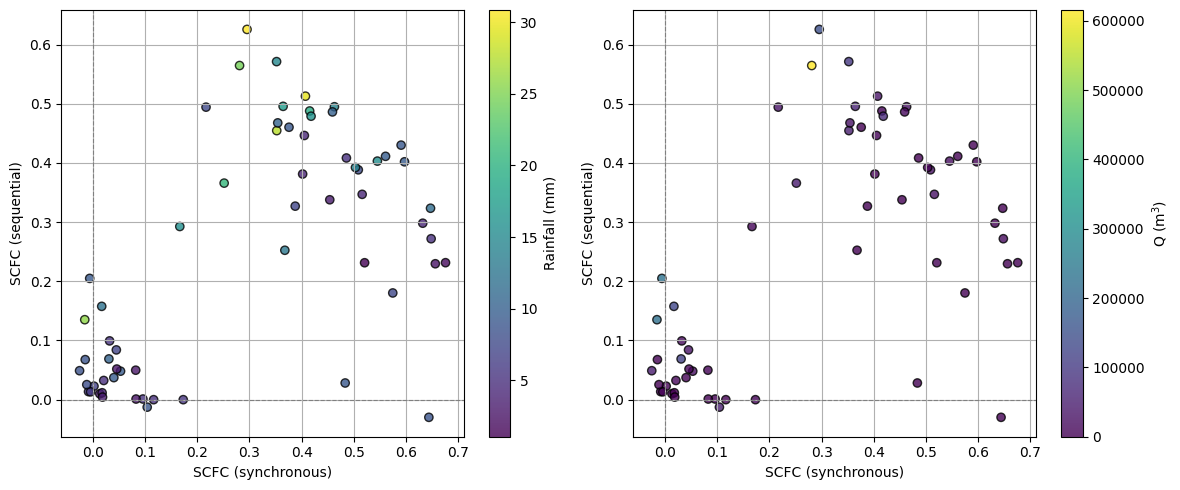

In [71]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(df_merged['scfc_sim'], df_merged['scfc_seq'],
            edgecolor='k', alpha=0.8, c=df_merged['rainfall_average_mm'],
            cmap='viridis' )
plt.xlabel("SCFC (synchronous)")
plt.ylabel("SCFC (sequential)")
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

colorbar1 = plt.colorbar(scatter1)
colorbar1.set_label("Rainfall (mm)")

plt.subplot(1, 2, 2)
scatter2 = plt.scatter(df_merged['scfc_sim'], df_merged['scfc_seq'],
            edgecolor='k', alpha=0.8, c=df_merged['flume_1'],
            cmap='viridis' )
plt.xlabel("SCFC (synchronous)")
plt.ylabel("SCFC (sequential)")
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

colorbar2 = plt.colorbar(scatter2)
colorbar2.set_label("Q (m$^3$)")

plt.tight_layout()
plt.show()

A key thing to note here is that there are events with fairly high $SC-FC_{seq}$  and $SC-FC_{sim}$, yet with low to no flow at the watershed outlet.

These high levels of connectivity within the watershed emphasize the importance of understanding the nature of connectivity within a system, and its effects on water redistribution, riparian processes, sediment transport and channel morphology.

##Tasks for you to have a think about:
What other types of exploratory analyses you could carry out to understand structural and functional connectivity their interactions, now that you've calculated at adjacency matrix and SC-FC correlations?

Can you plot out the correlation networks for $FC_{seq}$ for events with similar $SC-FC_{seq}$ values and explore how variable patterns of $FC_{seq}$ are for a given $SC-FC_{seq}$  value.

# References
Goodrich, D., Kepner, W. G., Levick, L., & Wigington Jr, P. (2018). Southwestern
intermittent and ephemeral stream connectivity. JAWRA Journal of the American Water Resources Association, 54 (2), 400–422.

Goodrich, D. C., Lane, L. J., Shillito, R. M., Miller, S. N., Syed, K. H., & Woolhiser, D. A. (1997). Linearity of basin response as a function of scale in a semiarid watershed. Water resources research, 33 (12), 2951–2965.

Heilman, P., Nichols, M., Goodrich, D., Miller, S., & Guertin, D. (2008). Geographic information systems database, Walnut Gulch Experimental Watershed, Arizona, United States. Water Resources Research, 44 (5).

Lu, H. et al (2024). Towards transient connectivity of river networks during rainfall events: Insight from hydrological observation and functional data
 analysis. Journal of Hydrology, 637 (131366).

Voutsa V et al. (2021) Two classes of functional connectivity in dynamical processes in networks. J. R. Soc. Interface 18: 20210486. https://doi.org/10.1098/rsif.2021.0486